In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [3]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',                                  'Proanthocyanins','Color intensity', 'Hue', 'OD280/                     OD315 of diluted wines',
                   'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/ OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)



In [6]:
#Feature scaling
#------normalize--------
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [7]:
#----standardize--------
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


In [8]:
#Implement L1
lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


In [9]:
lr.intercept_

array([-1.26392704, -1.21590013, -2.37006947])

In [10]:
lr.coef_

array([[ 1.24633087,  0.18051978,  0.74623799, -1.16386092,  0.        ,
         0.        ,  1.16075262,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55728283,  2.50860814],
       [-1.53749534, -0.38708499, -0.99593046,  0.3654827 , -0.05949365,
         0.        ,  0.66840113,  0.        ,  0.        , -1.93402766,
         1.23334492,  0.        , -2.23083928],
       [ 0.13580974,  0.16851509,  0.35715361,  0.        ,  0.        ,
         0.        , -2.43804865,  0.        ,  0.        ,  1.56366307,
        -0.8188489 , -0.49224192,  0.        ]])

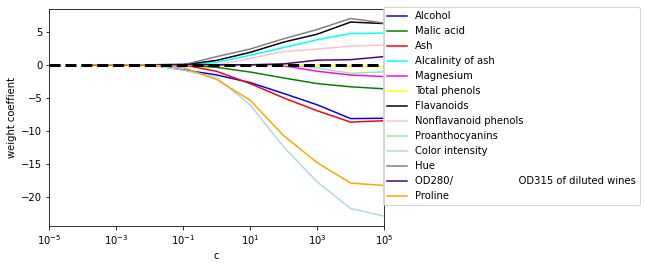

In [11]:
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4.,6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0, solver='liblinear')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params,weights[:, column],
    label = df_wine.columns[column + 1],
    color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coeffient')
plt.xlabel('c')
plt.xscale('log')
plt.legend(loc = 'upper left')
ax.legend(loc = 'upper center', bbox_to_anchor = (1.38, 1.03)
         , ncol = 1, fancybox = True)
plt.show()

In [12]:
#Sequential feature selection
#Implement SBS
class SBS():
        def __init__(self, estimator, k_features, scoring = accuracy_score,
                 test_size=0.25, random_state=1):
            self.scoring = scoring
            self.estimator = clone(estimator)
            self.k_features = k_features
            self.test_size = test_size
            self.random_state = random_state

        def fit(self, X, y):
            
            X_train, X_test, y_train, y_test =             train_test_split(X, y, test_size=self.test_size,
                                random_state=self.random_state)

            dim = X_train.shape[1]
            self.indices_ = tuple(range(dim))
            self.subsets_ = [self.indices_]
            score = self._calc_score(X_train, y_train, 
                                    X_test, y_test, self.indices_)
            self.scores_ = [score]

            while dim > self.k_features:
                scores = []
                subsets = []

                for p in combinations(self.indices_, r=dim - 1):
                    score = self._calc_score(X_train, y_train, 
                                            X_test, y_test, p)
                    scores.append(score)
                    subsets.append(p)

                best = np.argmax(scores)
                self.indices_ = subsets[best]
                self.subsets_.append(self.indices_)
                dim -= 1

                self.scores_.append(scores[best])
            self.k_score_ = self.scores_[-1]

            return self

        def transform(self, X):
            return X[:, self.indices_]
        
        def _calc_score(self, X_train, y_train, X_test, y_test, indices):
            self.estimator.fit(X_train[:, indices], y_train)
            y_pred = self.estimator.predict(X_test[:, indices])
            score = self.scoring(y_test,y_pred)
            return score
            

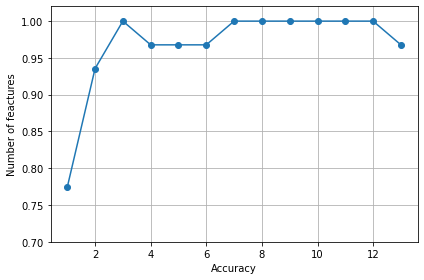

In [13]:
knn = KNeighborsClassifier(n_neighbors = 5)

#feature selection
sbs  = SBS(knn, k_features = 1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.xlabel('Accuracy')
plt.ylabel('Number of feactures')
plt.grid()
plt.tight_layout()
plt.show()

In [14]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index([&#39;Alcohol&#39;, &#39;Malic acid&#39;,
       &#39;OD280/                     OD315 of diluted wines&#39;],
      dtype=&#39;object&#39;)


In [15]:
knn.fit(X_train_std[:, k3], y_train)
print('Train accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Train accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/                     OD315 of diluted wines 0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


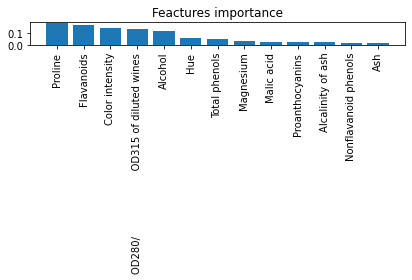

In [16]:
#Features with random forest

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500, random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feactures importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
            feat_labels[indices], rotation=90)        
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [17]:
#Features with SelectFromModel

sfm = SelectFromModel(forest, threshold = 0.1, prefit = True)
X_selected = sfm.transform(X_train)
print('Number of samples that meet this criterion:', X_selected[0])

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

Number of samples that meet this criterion: [ 13.62   0.8    4.4    2.05 550.  ]
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/                     OD315 of diluted wines 0.136162
 5) Alcohol                        0.118529
